In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [14]:
subsets = [
    "all",
]

model_feature = {
    "Enformer_L2_L2": "all",
    "Borzoi_L2_L2": "all",
    #"GPN-MSA_LLR": "score",
    "GPN-MSA_absLLR": "score",
    "CADD": "RawScore",
}
models = list(model_feature.keys())

palette = {model: f"C{i}" for i, model in enumerate(models)}

dfs = []
sample_size = {}

base_dir = f"../../results/dataset/gwas_matched_9"
#base_dir = f"../../results/dataset/omim_subsampled_9"
V = pd.read_parquet(f"{base_dir}/test.parquet")

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    for model in models:
        df = pd.read_csv(f"{base_dir}/unsupervised_metrics/{subset}/{model}.csv")
        df = df[df.feature == model_feature[model]].drop(columns=["feature"])
        df["Model"] = model
        df["subset"] = subset
        dfs.append(df)
df = pd.concat(dfs)
df

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]

,AUPRC,Model,subset
1,0.191004,Enformer_L2_L2,all
2,0.187332,Borzoi_L2_L2,all
0,0.169172,GPN-MSA_absLLR,all
2,0.166877,CADD,all


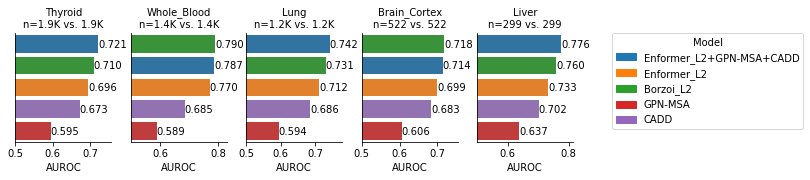

In [39]:
#nrows, ncols = 2, 3
#nrows, ncols = 4, 6
nrows, ncols = 1, 5

width, height = 2, 2

#wspace, hspace = 0.9, 0.9
wspace, hspace = None, 0.9

#metric = "AUPRC"
metric = "AUROC"

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=False, sharey=False,
    figsize=(width*ncols, height*nrows), squeeze=False,
    gridspec_kw={'wspace': wspace, 'hspace': hspace},
)

for subset, ax in zip(subsets, axes.flat):
    df_s = df[df.subset==subset].sort_values(metric, ascending=False)
    n_pos, n_neg = sample_size[subset]

    if metric == "AUROC":
        baseline = 0.5
    elif metric == "AUPRC":
        baseline = n_pos / (n_pos + n_neg)
    elif metric == "Odds ratio":
        baseline = 1

    g = sns.barplot(
        data=df_s,
        y="Model",
        x=metric,
        palette=palette,
        ax=ax,
    )
    sns.despine()
    sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    subtitle = f"{subset_renaming.get(subset, subset)}\n{sample_size_str}"
    g.set_title(subtitle, fontsize=10)
    g.set(
        xlim=baseline,
        ylabel="",
        yticks=[],
    )

    for bar, model in zip(g.patches, df_s.Model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

plt.legend(
    handles=[mpatches.Patch(color=palette[model], label=model) for model in models],
    #bbox_to_anchor=(1.4, 3.2),
    bbox_to_anchor=(1.4, 1.0),
    loc='upper left', borderaxespad=0.,
    title="Model",
)

In [9]:
df["n_pos"] = df.subset.apply(lambda x: sample_size[x][0])

def weighted_average(df):
    weights = df["n_pos"] / df["n_pos"].sum()
    return (df.AUPRC * weights).sum()

df_w = (
    df[df.subset!="all"].groupby("Model").apply(weighted_average).rename("AUPRC")
    .sort_values(ascending=False).to_frame().reset_index()
)
df_w

,Model,AUPRC
0,Enformer_L2+GPN-MSA+CADD,0.402273
1,Enformer_L2,0.386182
2,Borzoi_L2,0.383519
3,CADD,0.311857
4,GPN-MSA,0.288772


In [11]:
def single_barplot(subset, title):
    df_s = df[df.subset==subset]
    n_pos, n_neg = sample_size[subset]
    metric = "AUROC" if n_pos == n_neg else "AUPRC"
    if metric == "AUROC":
        baseline = 0.5
    elif metric == "AUPRC":
        baseline = n_pos / (n_pos + n_neg)
    elif metric == "Odds ratio":
        baseline = 1
    plt.figure(figsize=(2,2))
    g = sns.barplot(
        data=df_s,
        y="Model",
        x=metric,
        order=df_s.sort_values(metric, ascending=False).Model,
        palette=palette,
    )
    for bar, model in zip(g.patches, df_s.Model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )
    sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    g.set_title(f"{title}\n{sample_size_str}", fontsize=10)
    g.set(
        ylabel="",
        xlim=n_pos/(n_pos+n_neg),
    )
    sns.despine();

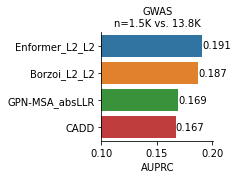

In [15]:
single_barplot("all", "GWAS")

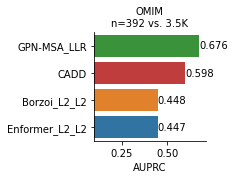

In [12]:
single_barplot("all", "OMIM")